<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Взвешивание-классов" data-toc-modified-id="Взвешивание-классов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взвешивание классов</a></span></li><li><span><a href="#Увеличение-выборки." data-toc-modified-id="Увеличение-выборки.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Увеличение выборки.</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li><li><span><a href="#Итоги-борьбы-с-дисбалансом" data-toc-modified-id="Итоги-борьбы-с-дисбалансом-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Итоги борьбы с дисбалансом</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Задача - получить метрику не менее 0.59. Проверим *F1*-меру на тестовой выборке.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.


## Подготовка данных

Импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Откроем файл с данными и ознакомимся с 5 первыми строками

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Оценим содержимое таблицы в цифрах на предмет пропусков и типов данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Вывод: 
<br>
<br>в таблице есть три столбца с данными строчного типа, с ними необходимо провести работу и привести их к численным значениям.**

Далее удалим столбец с ID пользователя, номером ряда и фамилией пользователя. Они ни к чему, только увеличивают объем данных и могут запутать модель.

In [4]:
data = data.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Заменим на 0 пропуски в столбце Tenure. Пропущенные значения могут означать, что клиент новый. Будем считать, что этим записям соответствует срок нахождения в клиентах банка = 0

In [5]:
data['Tenure'] = data['Tenure'].fillna(0.0)
data['Tenure'].value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: Tenure, dtype: int64

Проверим еще раз данные, убедимся, что пропуски ушли.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Применим технику прямого кодирования (One-Hot Encoding, OHE) для преобразования категориальных признаков в фиктивные (dummy) переменные. Используем для всего датафрейма функцию get_dummies(), указав параметр drop_first=True, чтобы исключить дамми-ловушку.

In [7]:
data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'] , axis=1)

Проведем масштабирование признаков при помощи StandardScaler. Таким образом избавимся от возможных ошибок при обучении и проверке модели ввиду разного масштаба отдельных признаков между собой.

In [8]:
numeric = ['CreditScore', 'Tenure', 'Balance', 'Age', 'EstimatedSalary', 'NumOfProducts']
scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])
features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-0.817441,-1.225848,-0.911583,1,1,0.021886,0,0,0
1,-0.440036,0.198164,-1.138838,0.117350,-0.911583,0,1,0.216534,0,1,0
2,-1.536794,0.293517,1.110941,1.333053,2.527057,1,0,0.240687,0,0,0
3,0.501521,0.007457,-1.138838,-1.225848,0.807737,0,0,-0.108918,0,0,0
4,2.063884,0.388871,-0.817441,0.785728,-0.911583,1,1,-0.365276,0,1,0


**Вывод: 
<br>
<br>Масштабирование проведено. Теперь значения признаков имеют соизмеримый порядок и явных преимуществ отдельные признаки не получат**



Далее разделим данные на три выборки: обучающую, валидационную и тестовую в соотношении 60/20/20 %

In [9]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)

Проверим размер получившихся выборок данных

Обучающая выборка

In [11]:
features_train.shape

(6000, 11)

Валидационная выборка

In [12]:
features_valid.shape

(2000, 11)

Тестовая выборка

In [13]:
features_test.shape

(2000, 11)

**Вывод: 
<br>
<br>разделение на выборки прошло корректно, с данными можно далее работать.**

## Исследование задачи

Проверим соотношение положительных и отрицательных значений целевого признака в имеющихся данных

In [14]:
data_ohe['Exited'].mean()

0.2037

**Вывод: 
<br>
<br>Положительных ответов, которые наша будущая модель будет "искать", почти в 4 раза меньше отрицательных. наблюдается дисбаланс классов, от соотношения 1:1 очень далеко**

Подберем оптимальные значения гиперпараметров для модели, обеспечивающие более высокую точность предсказаний. Для этого ниже запустим два отдельных цикла вычислений, для глубины дерева и количества деревьев соответственно:

In [15]:
%%time
best_result = 0

for depth in range(1, 16, 1):
    model = RandomForestClassifier(n_estimators=50, max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid) 
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_result = result 
print("max_depth =", depth, ": ", end='')

max_depth = 15 : CPU times: user 4.26 s, sys: 34.4 ms, total: 4.29 s
Wall time: 4.29 s


In [16]:
%%time
best_result = 0

for est in range(1, 50):
    model = RandomForestClassifier(n_estimators=est, max_depth=15, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid) 
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_result = result 
print("max_est =", est, ": ", end='')

max_est = 49 : CPU times: user 9.24 s, sys: 56.8 ms, total: 9.3 s
Wall time: 9.31 s


**Вывод: 
<br>
<br>По результатам вычислений получили оптимальные значения глубины дерева max_depth = 15 и количества деревьев леса n_estimators=49. Возьмем эти значения в качестве гиперпараметров для будущего использования модели Случайного леса и Дерева решений.**

Обучим несколько разных моделей на обучающей выборке без учета дисбаланса классов и изучим полученные на их основе значения метрики F1

Модель ДЕРЕВО РЕШЕНИЙ

In [17]:
model_tree = DecisionTreeClassifier(max_depth=15, random_state=12345)
model_tree.fit(features_train, target_train)
predictions_valid = model_tree.predict(features_valid) 
f1_score(target_valid, predictions_valid)

0.5199516324062878

Модель СЛУЧАЙНЫЙ ЛЕС

In [18]:
model_rf = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=12345)
model_rf.fit(features_train, target_train)
predictions_valid = model_rf.predict(features_valid) 
f1_score(target_valid, predictions_valid)

0.6008968609865472

Модель ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [19]:
model_lr = LogisticRegression(solver='liblinear', random_state=12345)
model_lr.fit(features_train, target_train)
predictions_valid = model_lr.predict(features_valid) 
f1_score(target_valid, predictions_valid)

0.3076923076923077

**Вывод: 
<br>
<br>Получены относительно невысокие значения метрики F1 для трех моделей. Отметим, что значение метрики в "Случайном лесе" значительно выше других и ближе к требуемой величине. Будем ориентироваться далее на эту модель как на оптимальную для тестирования и работы.**

## Борьба с дисбалансом

### Взвешивание классов

Проверим, как повлияет на метрику техника "взвешивания" классов. Добавим в разные модели аргумент class_weight = 'balanced', тем самым сделав веса классов сбалансированными. Изучим полученные метрики F1 для каждой модели

Модель ДЕРЕВО РЕШЕНИЙ (сбалансированные классы)

In [20]:
model_tree_balanced = DecisionTreeClassifier(random_state=12345, max_depth=15, class_weight = 'balanced')
model_tree_balanced.fit(features_train, target_train)
predicted_valid = model_tree_balanced.predict(features_valid)
print ('Метрика F1:', f1_score(target_valid,predicted_valid))
probabilities_valid = model_tree_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid )
print ('Площадь под кривой AUC-ROC: ', auc_roc)

Метрика F1: 0.5074285714285715
Площадь под кривой AUC-ROC:  0.697932832052419


Модель СЛУЧАЙНЫЙ ЛЕС (сбалансированные классы)

In [21]:
model_rf_balanced = RandomForestClassifier(n_estimators=49, random_state=12345, max_depth=15, class_weight = 'balanced')
model_rf_balanced.fit(features_train, target_train)
predicted_valid = model_rf_balanced.predict(features_valid)
print ('Метрика F1:', f1_score(target_valid,predicted_valid))
probabilities_valid = model_rf_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid )
print ('Площадь под кривой AUC-ROC: ', auc_roc)

Метрика F1: 0.5988200589970502
Площадь под кривой AUC-ROC:  0.859943097842152


Модель ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (сбалансированные классы)

In [22]:
model_lr_balanced = LogisticRegression(solver='liblinear', random_state=12345, class_weight = 'balanced')
model_lr_balanced.fit(features_train, target_train)
predictions_valid = model_lr_balanced.predict(features_valid) 
print ('Метрика F1:', f1_score(target_valid,predictions_valid))
probabilities_valid = model_lr_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid )
print ('Площадь под кривой AUC-ROC: ', auc_roc)

Метрика F1: 0.5302897278314311
Площадь под кривой AUC-ROC:  0.7937743250566558


**Вывод: 
<br>
<br>Балансировка классов положительно сказалась только на модели Логистической регрессии. Наблюдаемая метрика двух других моделей не сильно изменилась**

### Увеличение выборки.

Проверим, как повлияет на метрику Ф1 другой способ борьбы с дисбалансом классов - Upsampling или Увеличение выборки. Используем метод с разными моделями, чтобы найти наилучшую.

Модель ДЕРЕВО РЕШЕНИЙ (upsampling)

In [23]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

model_tree_us = DecisionTreeClassifier(random_state=12345, max_depth=15)
model_tree_us.fit(features_upsampled, target_upsampled)
predicted_valid = model_tree_us.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model_tree_us.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid )
print ('Площадь под кривой AUC-ROC: ', auc_roc)

F1: 0.5266821345707656
Площадь под кривой AUC-ROC:  0.7114309291555819


Модель СЛУЧАЙНЫЙ ЛЕС (upsampling)

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

model_rf_us = RandomForestClassifier(n_estimators=49, random_state=12345, max_depth=15)
model_rf_us.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf_us.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model_rf_us.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid )
print ('Площадь под кривой AUC-ROC: ', auc_roc)

F1: 0.6275
Площадь под кривой AUC-ROC:  0.8608206473544191


Модель ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (upsampling)

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

model_lr_us = LogisticRegression(solver='liblinear', random_state=12345)
model_lr_us.fit(features_upsampled, target_upsampled)
predicted_valid = model_lr_us.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model_lr_us.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid )
print ('Площадь под кривой AUC-ROC: ', auc_roc)

F1: 0.5052950075642965
Площадь под кривой AUC-ROC:  0.7946487954478273


**Вывод: 
<br>
<br>Метрика для каждой из примененных моделей еще немного увеличилась. Это показывает, что использование техники увеличения выборки - предпочтительней, она дает лучшие результаты, чем обычное взвешивание классов.**

### Уменьшение выборки

Далее проверим, как повлияет на метрику F1 еще один способ борьбы с дисбалансом классов - Downsampling или Уменьшение выборки. Используем все ту же модель Случайного леса, показавшую ранее наилучшие результаты в проверках.

Модель ДЕРЕВО РЕШЕНИЙ (downsampling)

In [26]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

model_tree_ds = DecisionTreeClassifier(random_state=12345, max_depth=15)
model_tree_ds.fit(features_downsampled, target_downsampled)
predicted_valid = model_tree_ds.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model_tree_ds.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid )
print ('Площадь под кривой AUC-ROC: ', auc_roc)

F1: 0.4390879478827362
Площадь под кривой AUC-ROC:  0.6639478027391861


Модель СЛУЧАЙНЫЙ ЛЕС (downsampling)

In [27]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

model_rf_ds = RandomForestClassifier(n_estimators=49, random_state=12345, max_depth=15)
model_rf_ds.fit(features_downsampled, target_downsampled)
predicted_valid = model_rf_ds.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model_rf_ds.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid )
print ('Площадь под кривой AUC-ROC: ', auc_roc)

F1: 0.469309462915601
Площадь под кривой AUC-ROC:  0.8490114481722337


Модель ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (downsampling)

In [28]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

model_lr_ds = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_ds.fit(features_downsampled, target_downsampled)
predicted_valid = model_lr_ds.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model_lr_ds.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid )
print ('Площадь под кривой AUC-ROC: ', auc_roc)

F1: 0.42151481888035125
Площадь под кривой AUC-ROC:  0.7987748177160312


**Вывод: 
<br>
<br>Эта методика не оправдала себя, значения метрики снизились в двух случаях из трех, и только при использовании модели Логистической регрессии метрика осталась на том же уровне. Использовать этот способ для решения нашей задачи не будем.**

### Итоги борьбы с дисбалансом

Из всех моделей, обученных в разных условиях и на разных выборках, увеличенных и уменьшенных, со сбалансированными классами и нет, наилучшее значение наблюдаемой метрики F1 показала модель Случайного леса с применением техники увеличения выборки (Upsampling) = 0.62, ее и будем использовать для тестирования модели.

Исследуем кривую ROC и вычислим значение площади под ней, чтобы наглядно убедиться в отличии модели от случайной и оценить ее качество

Площадь AUC-ROC =  0.8608206473544191


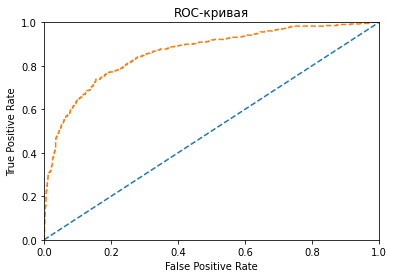

In [29]:
probabilities_valid = model_rf_us.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print ('Площадь AUC-ROC = ', auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC-кривая')
plt.show()

Найдем оптимальное значение порога классификации, чтобы далее использовать его в тестировании модели и получения максимально возможного значения исследуемой метрики F1

In [30]:
probabilities_valid = model_rf_us.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.2, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | F1= {:.3f}".format(
        threshold, f1))   

Порог = 0.20 | F1= 0.531
Порог = 0.22 | F1= 0.551
Порог = 0.24 | F1= 0.563
Порог = 0.26 | F1= 0.574
Порог = 0.28 | F1= 0.583
Порог = 0.30 | F1= 0.590
Порог = 0.32 | F1= 0.603
Порог = 0.34 | F1= 0.613
Порог = 0.36 | F1= 0.624
Порог = 0.38 | F1= 0.628
Порог = 0.40 | F1= 0.620
Порог = 0.42 | F1= 0.623
Порог = 0.44 | F1= 0.630
Порог = 0.46 | F1= 0.631
Порог = 0.48 | F1= 0.633
Порог = 0.50 | F1= 0.627
Порог = 0.52 | F1= 0.626
Порог = 0.54 | F1= 0.620
Порог = 0.56 | F1= 0.620
Порог = 0.58 | F1= 0.618
Порог = 0.60 | F1= 0.609
Порог = 0.62 | F1= 0.601
Порог = 0.64 | F1= 0.595
Порог = 0.66 | F1= 0.590
Порог = 0.68 | F1= 0.577


Вывод: после проверки на валидационной выборке разных значений порога вероятности предсказаний модели получили значение порога = 0,48, при котором метрика F1 имеет максимальное значение. По достижении этого порога значение метрики начинает снижаться. Используем данный порог при тестировании модели.

## Тестирование модели

Проверим работу лучшей модели на тестовой выборке, используя значение порога 0.48, полученное ранее.

In [31]:
threshold = 0.48
predicted_probs = model_rf_us.predict_proba(features_test)
prediction_values = (predicted_probs [:,1] >= threshold).astype('int')
print(f'F1: {f1_score(target_test,prediction_values)}')


F1: 0.5847665847665847


Значение метрики близко к требуемому 0,59, но попробуем поднять его еще немного. Для этого проведем слияние валидационной и тестовой выборок. Валидационная уже "отработала" своё, можем ее включить в тестовый набор данных. Перемешаем данные после объединения с помощью функции shuffle

In [35]:
target_final = pd.concat([target_valid, target_test])
features_final = pd.concat([features_valid, features_test])
features_final, target_final = shuffle(
        features_final, target_final, random_state=12345)

Протестируем модель на полученной объединенной выборке

In [36]:
probabilities_test = model_rf_us.predict_proba(features_final)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = (probabilities_one_test >= 0.46).astype('int')
f1_score(target_final, predicted_test)

0.6100478468899522

**Вывод:  
<br>после объединения тестовой выборки с валидационной мы получили немного увеличенную метрику F1, что скажется положительно на результате**

In [37]:
probabilities_test = model_lr_ds.predict_proba(features_test)
probabilities_one_test= probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print ('Площадь под кривой ROC (AUC-ROC) = ', auc_roc)

Площадь под кривой ROC (AUC-ROC) =  0.7581032496286733


**Вывод:   
<br>наша модель далека от идеальной, но условный минимальный показатель метрики F1 = 0,59 преодолен. Площадь под кривой ROC выше 0,75 говорит о том, насколько наша модель отличается от случайной, у которой это значение равнялось бы 0,5.**